In [1]:
# import stuff
%load_ext autoreload
%autoreload 2
%matplotlib inline

from random import randint

import numpy as np
import torch
import nltk
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Theo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
import numpy as np
import torch
import yaml
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader

import sys
sys.path.append("../../Text-to-Image-Synthesis/") # à changer selon l'emplacement de ce dossier, pull récent de aelnouby

from txt2image_dataset import Text2ImageDataset
from utils import Utils, Logger
from PIL import Image
import h5py

Créer un modèle à partir d'InferSent.

In [3]:
from models_ import InferSent
model_version = 1
MODEL_PATH = "../encoder/infersent%s.pickle" % model_version
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': model_version}
model = InferSent(params_model)
model.load_state_dict(torch.load(MODEL_PATH))

# Keep it on CPU or put it on GPU
use_cuda = True
model = model.cuda() if use_cuda else model

# If infersent1 -> use GloVe embeddings. If infersent2 -> use InferSent embeddings.
W2V_PATH = '../dataset/GloVe/glove.840B.300d.txt' if model_version == 1 else '../dataset/fastText/crawl-300d-2M.vec'
model.set_w2v_path(W2V_PATH)

Attention, il faut changer le fichier "config.yaml" en fonction de l'emplacement des textes pour les oiseaux.

Ici, on se contente de récupérer les textes dans la variable sentences

In [4]:
import os
from os import listdir
from glob import glob
with open('../../Text-to-Image-Synthesis/config.yaml', 'r') as f:
    config = yaml.load(f)
    
text_path = config['flowers_text_path']
it = 0
sentences = []

for _class in sorted(listdir(text_path)):
    txt_path = os.path.join(text_path, _class)
    it+=1
    for txt_file in sorted(glob(txt_path + "/*.txt")):
        f = open(txt_file, "r")
        txt = f.readlines()
        f.close()
        sentences.extend(np.array([line.replace("\n","") for line in txt]))
    if it%20 == 0:
        print(it/2)

5.0
10.0
15.0
20.0
25.0
30.0
35.0
40.0
45.0
50.0


In [5]:
len(sentences)

81890

Ici, on construit le vocabulaire de notre modèle.

In [6]:
model.build_vocab(sentences, tokenize=True)

Found 5065(/6251) words with w2v vectors
Vocab size : 5065


Ici on encode les phrases par classe (il y en a 200 pour les oiseaux) dans des fichiers .t7.
Ne pas s'inquiéter si on obtient une erreur à la fin du processus, c'est juste qu'on essaye de traiter des fichiers inutiles.

Dans le cas suivant, on obtient un fichier t7 par classe, de dimension 4096 * le nombre d'éléments dans la classe.

In [95]:
# from os import mkdir
# l = len(sentences)
# it = 0
# save_path = "embeddings/"
# for _class in sorted(listdir(text_path)):
#     txt_path = os.path.join(text_path, _class)
#     class_path = save_path+_class
#     if (_class not in listdir(save_path)) and _class[-2:]!="t7" and _class[-2:]!="h5":
#         dim = int(len(listdir(txt_path))/2) # parce qu'on a une copie inutile du texte à chaque fois
#         torch.save(model.encode(sentences[it:it+dim]), class_path + ".t7")
#         it=it+dim
#         print(_class+" created")

001.Black_footed_Albatross created
002.Laysan_Albatross created
003.Sooty_Albatross created
004.Groove_billed_Ani created
005.Crested_Auklet created
006.Least_Auklet created
007.Parakeet_Auklet created
008.Rhinoceros_Auklet created
009.Brewer_Blackbird created
010.Red_winged_Blackbird created
011.Rusty_Blackbird created
012.Yellow_headed_Blackbird created
013.Bobolink created
014.Indigo_Bunting created
015.Lazuli_Bunting created
016.Painted_Bunting created
017.Cardinal created
018.Spotted_Catbird created
019.Gray_Catbird created
020.Yellow_breasted_Chat created
021.Eastern_Towhee created
022.Chuck_will_Widow created
023.Brandt_Cormorant created
024.Red_faced_Cormorant created
025.Pelagic_Cormorant created
026.Bronzed_Cowbird created
027.Shiny_Cowbird created
028.Brown_Creeper created
029.American_Crow created
030.Fish_Crow created
031.Black_billed_Cuckoo created
032.Mangrove_Cuckoo created
033.Yellow_billed_Cuckoo created
034.Gray_crowned_Rosy_Finch created
035.Purple_Finch created
036

NotADirectoryError: [WinError 267] Nom de répertoire non valide: 'C:/Users/Theo/Documents/GitHub/Text-to-Image-Synthesis/data/cvpr2016_cub/text_c10/Black_Footed_Albatross_0001_796111.h5'

Dans ce cas, on créé un fichier .t7 par image.

In [7]:
from os import mkdir
l = len(sentences)
it = 0
save_path = "embeddings_flowers/"
for _class in sorted(listdir(text_path)):
    txt_path = os.path.join(text_path, _class)
    class_path = save_path+_class
    if (_class not in listdir(save_path)) and _class[-2:]!="t7" and _class[-2:]!="h5":
        mkdir(class_path)
        for file in sorted(listdir(txt_path)):
            if file[-2:]!="h5":
                file_path = class_path + "/" + file
                torch.save(model.encode(sentences[it:it+10]), file_path[:-4] + ".t7")
                it+=10
        print(_class+" created")

class_00001 created
class_00002 created
class_00003 created
class_00004 created
class_00005 created
class_00006 created
class_00007 created
class_00008 created
class_00009 created
class_00010 created
class_00011 created
class_00012 created
class_00013 created
class_00014 created
class_00015 created
class_00016 created
class_00017 created
class_00018 created
class_00019 created
class_00020 created
class_00021 created
class_00022 created
class_00023 created
class_00024 created
class_00025 created
class_00026 created
class_00027 created
class_00028 created
class_00029 created
class_00030 created
class_00031 created
class_00032 created
class_00033 created
class_00034 created
class_00035 created
class_00036 created
class_00037 created
class_00038 created
class_00039 created
class_00040 created
class_00041 created
class_00042 created
class_00043 created
class_00044 created
class_00045 created
class_00046 created
class_00047 created
class_00048 created
class_00049 created
class_00050 created


In [8]:
np.shape(model.encode([sentences[0]], tokenize=True))

(1, 4096)

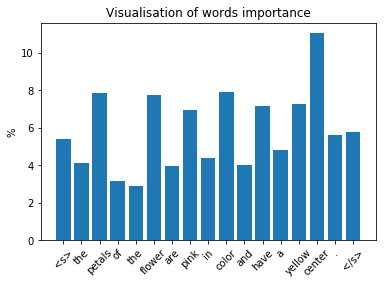

(tensor([[ 0.1024,  0.1611,  0.0802,  ...,  0.0169, -0.0381, -0.0284]],
        device='cuda:0', grad_fn=<MaxBackward0>),
 array([[ 8,  5, 13, ...,  1, 16,  9]], dtype=int64))

In [9]:
model.visualize(sentences[0], tokenize=True)

In [11]:
torch.save(model,"model_flowers.t7")

In [3]:
from models_ import InferSent

In [4]:
model = torch.load("model_flowers.t7")

In [6]:
embed = model.encode(["the flower has a blue center with red petals"])

In [12]:
np.size(embed)

4096